* https://www.slideshare.net/0xdata/distributed-learning-of-rule-ensemble-models-with-h2o?from_action=save

**Chapter 7 – Ensemble Learning and Random Forests**

* 군중의 지혜(the wisdom of the crowd)
    * 수천명의 랜덤한 사람들에게 어려운 문제를 묻고, 그들의 답을 모아보는 것이 전문가 한사람에게 묻는것 보다 좋을 수 있다.

* 한 그룹의 분류기(분류, 회귀)의 예측결과를 모으는 것이 가장 좋은 한 분류기의 예측보다 좋을 수 있다.

* 한 그룹의 분류기를 Ensemble이라함

* 이러한 학습 방법을 Ensemble learning, Ensemble learning algorithm을 Ensemble method라고 함

* 예를 들어, 한 그룹의 Decision Tree를 각각 다른 랜덤한 서브 학습셋으로 학습시킨다면, 각 분류기의 결과를 얻을 수 있을것이고, 그 결과를 투표시킬 수 있다.
* Decision Tree들의 ensemble을 Random Forest라 부른다.

In [1]:
import IPython
url = 'https://netflixprize.com/leaderboard.html'
iframe = """<style>
    #frame {
        -ms-zoom: 0.7;
        -moz-transform: scale(0.7);
        -moz-transform-origin: 0 0;
        -o-transform: scale(0.7);
        -o-transform-origin: 0 0;
        -webkit-transform: scale(0.7);
        -webkit-transform-origin: 0 0;
    }
</style>
<div id="frame">
    <iframe src=""" + url + """ width=1280 height=720></iframe>
</div>
    """

In [2]:
IPython.display.HTML(iframe)

* 이번 장에서 유명한 Ensemble methods에 관해 다룸
* bagging, boosting, stacking, etcs

In [35]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ensembles"

def image_path(fig_id):
    return os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path(fig_id) + ".png", format='png', dpi=300)

# Voting classifiers

* 각각 80%정도 정확도를 가지는 LR, SVM, RF, KNN같은 모델들이 있을때, 더 좋은 분류기를 만들어내는 방법은 각 분류기의 예측결과를 다수결로 voting하는 것이다.
* 이러한 다수결 voting을 hard voting 이라 부른다.
* 이러한 방식은 보통 최고성능을 내는 단일 분류기보다 성능이좋고, 각 분류기의 성능이 나쁘더라도 충분한수의 분류기와 다양성이 만족된다면 여전히 좋은 성능을 낼수있다.

* 이것이 가능한 이유는 큰 수의 법칙 때문이다. 
* 동전던지기에서 head쪽으로 1%정도의 bias를 준다면 1000번 던졌을때는 510번 head가 나오게 되지만, 1000번 이후에는 75%가까운 확률로 head가 나오는걸 볼수있다. 그리고 10000번 정도가 되면 확률을 97%까지 올라간다.

In [2]:
heads_proba = 0.51
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads_ratio = np.cumsum(coin_tosses, axis=0) / np.arange(1, 10001).reshape(-1, 1)

Saving figure law_of_large_numbers_plot


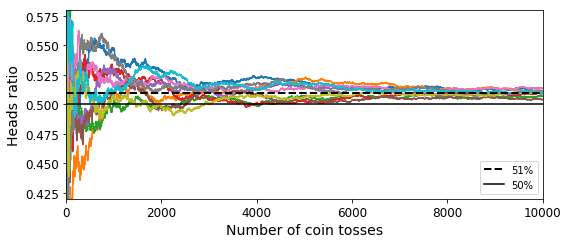

In [3]:
plt.figure(figsize=(8,3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
save_fig("law_of_large_numbers_plot")
plt.show()

* 분류기 문제도 이와 유사할 수있다고 생각되지만, 막상 적용해보면 성능이 잘 나오지 않는데, 
* 그 이유는 같은 학습데이터를 사용하다보니 비슷한 문제의 유형에 대해 틀리기 때문이다.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

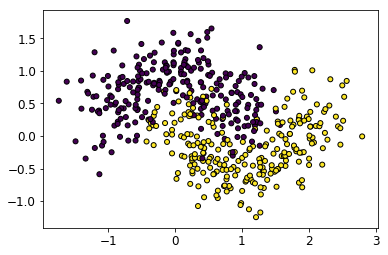

In [5]:
plt.scatter(X[:, 0], X[:, 1], marker='o', c=y,
            s=25, edgecolor='k')

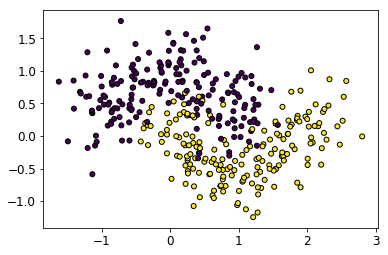

In [6]:
plt.scatter(X_train[:,0], X_train[:,1], marker='o', c=y_train, s=25, edgecolors='k')

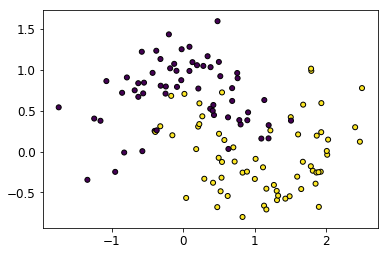

In [7]:
plt.scatter(X_test[:,0], X_test[:,1], marker='o', c=y_test, s=25, edgecolors='k')

* 분류기중 확률이 제일 높은 클래스로 예측하는 방법을 soft voting이라 한다.
* 보통 hard voting 보다 성능이 좋은데, 높은 확률 voting에 대해 가중치를 더주기 때문.
* sklearn에서는 voting="hard" with voting="soft" 옵션으로 조절가능
* SVC분류기는 probability=True를 줘서 클래스에 대한 예측 확률을 출력

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...f',
  max_iter=-1, probability=False, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='hard', weights=None)

In [9]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.896


In [10]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=42, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)), ('rf', RandomFor...bf',
  max_iter=-1, probability=True, random_state=42, shrinking=True,
  tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=1, voting='soft', weights=None)

In [39]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.864
RandomForestClassifier 0.872
SVC 0.888
VotingClassifier 0.912


#### TIP
* 각 분류기를 매우 다른 알고리즘으로 학습하면 성능을 높일 수 있다.

# Bagging ensembles

* 위와는 다른방법으로 같은 알고리즘을 사용하지만 훈련데이터셋의 일부를 다르게 적용한 ensemble방법이 있다.
* 샘플링에서 replacement가 일어나면 bagging, 안일어나면 pasting이라 부른다.

* bagging과 pasting은 훈련 인스턴스가 여러번에 걸쳐 다수의 분류기에 샘플되지만, bagging은 특히 같은 분류기에서 계속 샘플링되게 함

* ensemble방식으로 새로운 데이터에 대해서 예측한 결과를 집계하고 분류에 대해서는 hard voting방식으로 회귀에 대해서는 평균으로 예측
* 각 분류기는 높은 bias를 가지고 있지만 aggregation이 bias와 variance를 낮게해줌.
* 한개의 분류기로 전체 데이터를 학습한 결과와 bias는 유사하지만, variance는 보통 낮음.
* 병렬처리가 가능하기 때문에 scale하기 좋음

#### Bagging and Pasting in Scikit-Learn
* Scikit-Learn에서는 bagging과 pasting에 대한 api를 제공.
    * (BaggingClassifier, BaggingRegressor)
* bootstrap 옵션을 true로 주면 bagging, false로 주면 pasting
* n_estimators = 트리 갯수
* max_samples = 샘플링 데이터 수
* n_jobs = 사용 CPU core수

* 한개의 Decision Tree와 비교했을 때 bias는 유사하지만 variance는 적다.
* bagging이 pasting보다 bias가 조금더 높지만, 분류기 사이에 연관도가 적기 때문에 variance감소 효과가 있다
* 여유 시간과 CPU파워에 여유가 있다면 bagging이나 pasting중에 더 좋은 걸 사용하라.

In [40]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [41]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred))

0.904


In [42]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.856


In [43]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap, linewidth=10)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [44]:
axes=[-1.5, 2.5, -1, 1.5]
x1s = np.linspace(axes[0], axes[1], 100)
x2s = np.linspace(axes[2], axes[3], 100)
x1, x2 = np.meshgrid(x1s, x2s)

Saving figure decision_tree_without_and_with_bagging_plot


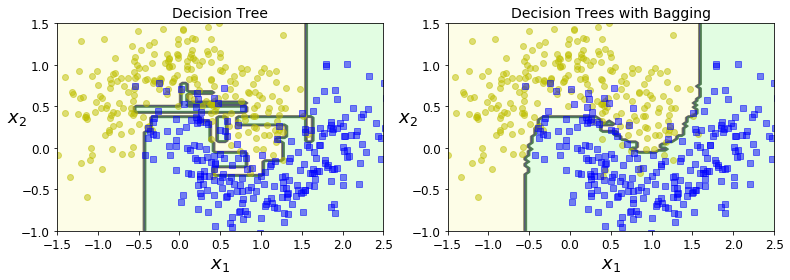

In [45]:
plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

# Random Forests

* BaggingClassifier 클래스에 DecisionTreeClassifier를 붙여 RF를 만들수있지만, RandomForestClassifier클래스를 제공해줌
* RandomForestClassifier가 random subset feature중에서 나누기 좋은 feature를 찾기 때문에 tree가 자라는데 랜덤성을 더해준다.

In [46]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1, random_state=42)

In [47]:
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

In [48]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

In [49]:
np.sum(y_pred == y_pred_rf) / len(y_pred)  # almost identical predictions

0.97599999999999998

In [50]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.112492250999
sepal width (cm) 0.0231192882825
petal length (cm) 0.441030464364
petal width (cm) 0.423357996355


In [51]:
rnd_clf.feature_importances_

array([ 0.11249225,  0.02311929,  0.44103046,  0.423358  ])

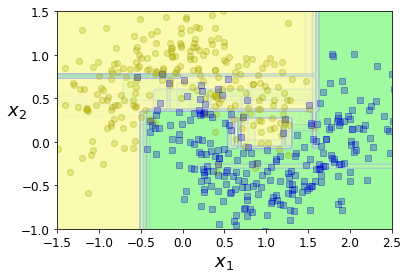

In [52]:
plt.figure(figsize=(6, 4))

for i in range(15):
    tree_clf = DecisionTreeClassifier(max_leaf_nodes=16, random_state=42 + i)
    indices_with_replacement = np.random.randint(0, len(X_train), len(X_train))
    tree_clf.fit(X[indices_with_replacement], y[indices_with_replacement])
    plot_decision_boundary(tree_clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.02, contour=False)

plt.show()

## Out-of-Bag evaluation

* Bagging에서는 전체 훈련 데이터중 67%정도만 샘플링되고 37%정도는 사용되지 않는데 이러한 데이터를 oob(out-of-bag)이라 한다.
* 37%가 Bagging에 사용되는 모든 분류기사이에 동일하진 않다.
* 이러한 oob를 따로 cv를 돌리지 않아도 검증용으로 사용할 수 있다.
* Scikit-Learn에서는 oob_score=True로 두면 학습 후에 자동으로 검증해준다.
* 검증 결과도 oob_score_라는 변수에 담아준다.
* oob에 대해서 어떻게 분류했는지도 oob_decision_function_변수를 통해 얻을 수 있다.

In [27]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True, random_state=40)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.90133333333333332

In [29]:
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.91200000000000003

In [28]:
bag_clf.oob_decision_function_

array([[ 0.31746032,  0.68253968],
       [ 0.34117647,  0.65882353],
       [ 1.        ,  0.        ],
       [ 0.        ,  1.        ],
       [ 0.        ,  1.        ],
       [ 0.08379888,  0.91620112],
       [ 0.31693989,  0.68306011],
       [ 0.02923977,  0.97076023],
       [ 0.97687861,  0.02312139],
       [ 0.97765363,  0.02234637],
       [ 0.74404762,  0.25595238],
       [ 0.        ,  1.        ],
       [ 0.71195652,  0.28804348],
       [ 0.83957219,  0.16042781],
       [ 0.97777778,  0.02222222],
       [ 0.0625    ,  0.9375    ],
       [ 0.        ,  1.        ],
       [ 0.97297297,  0.02702703],
       [ 0.95238095,  0.04761905],
       [ 1.        ,  0.        ],
       [ 0.01704545,  0.98295455],
       [ 0.38947368,  0.61052632],
       [ 0.88700565,  0.11299435],
       [ 1.        ,  0.        ],
       [ 0.96685083,  0.03314917],
       [ 0.        ,  1.        ],
       [ 0.99428571,  0.00571429],
       [ 1.        ,  0.        ],
       [ 0.        ,

## Feature importance

* 학습과정중에 전체 분류기에서 impurity를 낮추는 feature의 중요도
* Scikit-Learn에서는 자동으로 FI를 뽑아줌.
* 전체 FI의 합은 1
* feature_importances_ 변수로 얻음
* MNIST 데이터를 예로 pixel에 대한 importance를 구해서 시각화도 할수있음

In [65]:
from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')

In [66]:
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [67]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

Saving figure mnist_feature_importance_plot


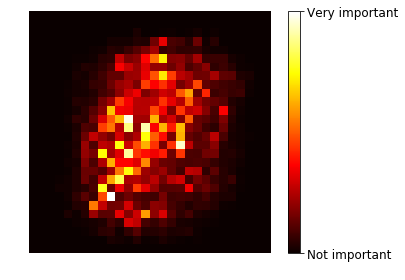

In [68]:
plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

# AdaBoost

* 이어지는 분류기가 앞 분류기의 오류를 고칠 한가지 방법은 잘못분류한 학습데이터에 집중하는것
* 먼저 잘못 분류된 데이터의 가중치가 높아짐.
* 분류기는 가중치를 반영하여 다시 학습하게되고 이것을 반복
* GD와 비슷한데, cost function을 최소화하는 하나의 분류기 대신, AdaBoost에서는 분류기들을 연이어 학습해서(ensemble) 성능을 높임
<P>
</P>
* 단점 : 병렬처리가 힘들다.

In [34]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(algorithm='SAMME.R',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=200, random_state=42)

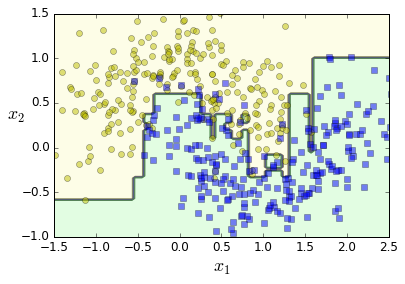

In [29]:
plot_decision_boundary(ada_clf, X, y)

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

[ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1

[ 1.       1.       1.       1.       1.       1.       7.59375  1.       1.
  3.375    7.59375  1.       1.       1.       1.       1.       1.       1.
  1.       1.       1.       1.       1.       1.       1.       1.       1.
  1.       1.       1.       1.       1.       1.       1.       1.       1.
  1.       7.59375  1.       1.       1.       1.       1.       1.       1.
  1.       1.       1.       1.       1.       1.       7.59375  1.
  7.59375  1.       1.       1.       1.       1.       1.       1.       5.0625
  1.       7.59375  1.       1.       1.       1.       2.25     1.       1.
  5.0625   1.       5.0625   1.       3.375    1.       1.       1.       1.
  1.       3.375    1.       5.0625   1.       1.       7.59375  1.       1.
  1.       1.       1.       1.       1.5      1.       5.0625   7.59375
  1.       1.       5.0625   1.       1.       1.       5.0625   1.       1.
  7.59375  5.0625   1.       1.       1.5      1.       1.       3.375    1.
  1.    

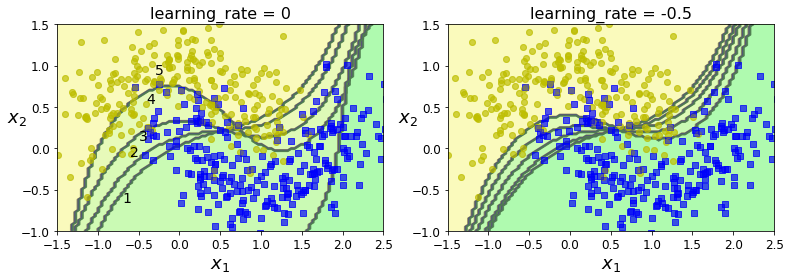

In [75]:
m = len(X_train)

plt.figure(figsize=(11, 4))
for subplot, learning_rate in ((121, 1), (122, 0.5)):
    sample_weights = np.ones(m)
    print(sample_weights)
    for i in range(5):
        plt.subplot(subplot)
        svm_clf = SVC(kernel="rbf", C=0.05, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights)
        y_pred = svm_clf.predict(X_train)
        sample_weights[y_pred != y_train] *= (1 + learning_rate)
        print('%s th iter')
        print(sample_weights)
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate - 1), fontsize=16)

plt.subplot(121)
plt.text(-0.7, -0.65, "1", fontsize=14)
plt.text(-0.6, -0.10, "2", fontsize=14)
plt.text(-0.5,  0.10, "3", fontsize=14)
plt.text(-0.4,  0.55, "4", fontsize=14)
plt.text(-0.3,  0.90, "5", fontsize=14)
save_fig("boosting_plot")
plt.show()

In [31]:
list(m for m in dir(ada_clf) if not m.startswith("_") and m.endswith("_"))

['base_estimator_',
 'classes_',
 'estimator_errors_',
 'estimator_weights_',
 'estimators_',
 'feature_importances_',
 'n_classes_']

# Gradient Boosting

* Adaboost와 같이 연속적인 학습방법을 가지지만, 매 iteration마다 weight값을 구하는게 아니라, 이전 분류기에 의해 만들어진 residual error를 적합함

In [93]:
np.random.seed(42)
X = np.random.rand(100,1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [95]:
print(X.shape)
print(y.shape)

(100, 1)
(100,)


In [97]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [98]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [99]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=42, splitter='best')

In [100]:
X_new = np.array([[0.8]])

In [101]:
y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

In [110]:
print(tree_reg1.predict(X_new))
print(tree_reg2.predict(X_new))
print(tree_reg3.predict(X_new))

[ 0.52856846]
[ 0.03991297]
[ 0.18178637]


In [102]:
y_pred

array([ 0.75026781])

In [117]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

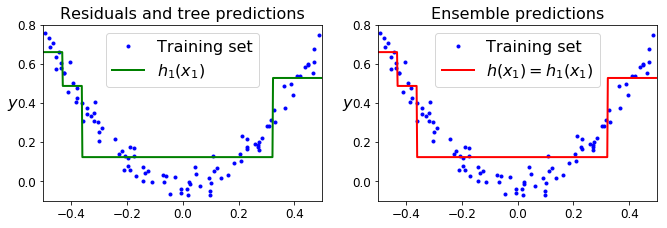

In [118]:
plt.figure(figsize=(11,11))
plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

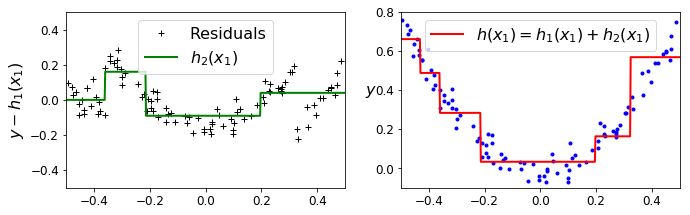

In [119]:
plt.figure(figsize=(11,11))
plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

Saving figure gradient_boosting_plot


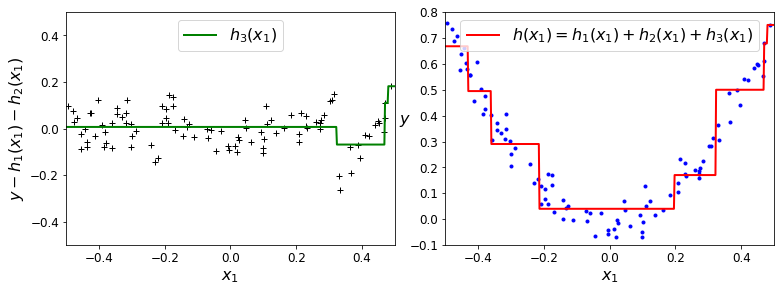

In [120]:
plt.figure(figsize=(11,11))
plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

In [124]:
# 분류기가 3개인 모델
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=1.0, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=3, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [125]:
# 분류기가 200개인 모델
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=200, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

Saving figure gbrt_learning_rate_plot


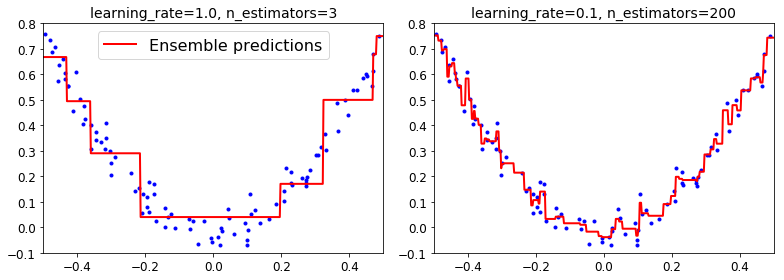

In [126]:
# 두 모델 비교
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

save_fig("gbrt_learning_rate_plot")
plt.show()

## Gradient Boosting with Early stopping

* optimal한 tree의 수를 찾기 위한 방법으로 학습을 조기 종료 할수있음

In [127]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors)

gbrt_best = GradientBoostingRegressor(max_depth=2,n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=2, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=55, presort='auto', random_state=42,
             subsample=1.0, verbose=0, warm_start=False)

In [134]:
# 최소 에러율 index
bst_n_estimators = np.argmin(errors)
print(bst_n_estimators)

# 최소 에러율
min_error = np.min(errors)
print(min_error)

55
0.00271285332524


Saving figure early_stopping_gbrt_plot


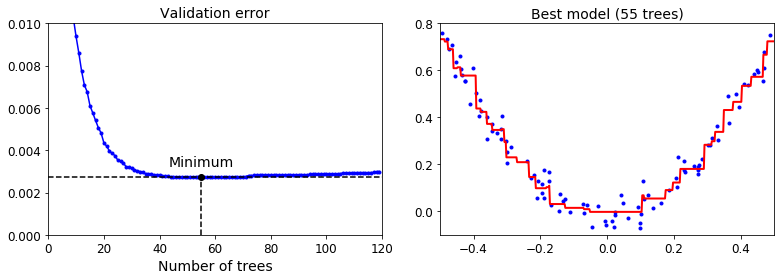

In [135]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

save_fig("early_stopping_gbrt_plot")
plt.show()

In [136]:
# warm_start 옵션으로 iteration마다의 에러율 하강/증강을 비교 가능
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break  # early stopping

In [137]:
print(gbrt.n_estimators)

61


# References

https://github.com/szilard/GBM-perf
https://catboost.yandex/#benchmark
http://xgboost.readthedocs.io/en/latest/model.html